In [ ]:

#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tcn import TCN
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
#load the data
data = pd.read_csv(r"C:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\starbucks_open_7year.csv")


In [3]:
#checking fir missing data
data.fillna(method='ffill', inplace=True)

C:\Users\Bhumika Reddy\AppData\Local\Temp\ipykernel_17356\2669196683.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [4]:
#preprocessing the data
data['Date'] =pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

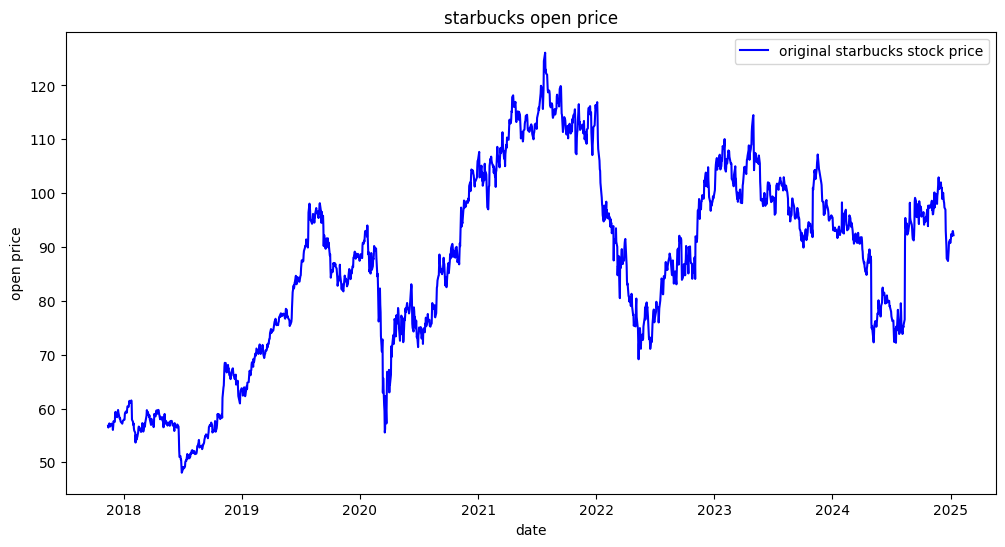

In [8]:
#visualising the data
plt.figure(figsize=(12, 6))
plt.plot(data['Open'],label='original starbucks stock price',color='blue')
plt.title('starbucks open price')
plt.xlabel('date')
plt.ylabel('open price')
plt.legend()
plt.show()

In [9]:
scaler=MinMaxScaler(feature_range=(0, 1))
scaled_data=scaler.fit_transform(data[['Open']])

In [10]:
#creating sequence
def create_sequences(data,time_step=60):
    x, y = [], []
    for i in range(len(data)-time_step):
        x.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(x),np.array(y)

In [11]:
#split into training,validation and testing
train_size=int(len(scaled_data)*0.6)
validation_size=int(len(scaled_data)*0.2)
test_size=len(scaled_data)-train_size-validation_size

train_data=scaled_data[:train_size]
validation_data=scaled_data[train_size:train_size+ validation_size]
test_data=scaled_data[train_size+ validation_size:]

In [12]:
#create sequences for training,validation and testing data
time_step = 60
x_train,y_train=create_sequences(train_data,time_step)
x_val,y_val=create_sequences(validation_data,time_step)
x_test,y_test=create_sequences(test_data,time_step)

In [13]:
x_train=np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_val=np.reshape(x_val,(x_val.shape[0], x_val.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [14]:
#tcn model
model=Sequential()
model.add(TCN(input_shape=(x_train.shape[1], 1),nb_filters=64,kernel_size=3,nb_stacks=1,dilations=[1, 2, 4, 8]))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_val, y_val))


c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\tcn\tcn.py:263: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)



Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 4.8232 - val_loss: 0.0720
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3408 - val_loss: 0.0026
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1395 - val_loss: 0.0049
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0715 - val_loss: 0.0029
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0453 - val_loss: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0239 - val_loss: 0.0019
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0198 - val_loss: 0.0011
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106 - val_loss: 0.0013
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0083 - val_loss: 8.6789e-04
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - val_loss: 8.0422e-04
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - 

In [15]:
#predictions
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [23]:
#model evaluation
mse = mean_squared_error(y_test_actual,predicted_stock_price)
mae = mean_absolute_error(y_test_actual,predicted_stock_price)
r2 = r2_score(y_test_actual,predicted_stock_price)
mape = mean_absolute_percentage_error(y_test_actual, predicted_stock_price)

In [24]:
print(f'MSE:{mse}')
print(f'MAE:{mae}')
print(f'R²:{r2}')
print(f'MAPE: {mape}')

MSE:8.673856976418692
MAE:2.361869166463215
R²:0.8854025178108357
MAPE: 0.026089293173551156


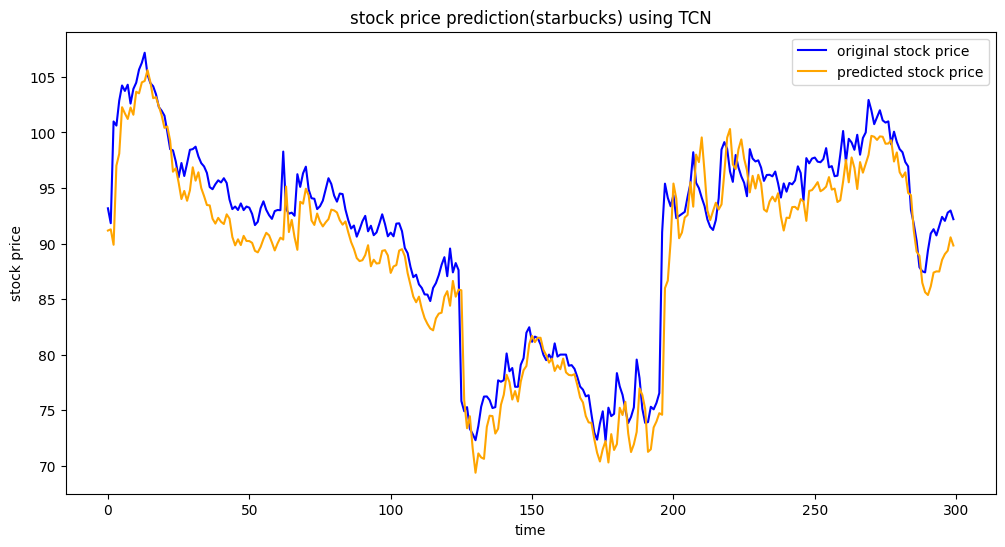

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='original stock price',color='blue')
plt.plot(predicted_stock_price,label='predicted stock price',color='orange')
plt.title('stock price prediction(starbucks) using TCN')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()